# Cyclic QAOA on two-regular graphs with fixed $p$

Examples from section 4 of the QAOA paper.

In [52]:
from typing import Sequence, Tuple, List
import numpy as np
import sympy
from scipy.constants import pi
import matplotlib.pyplot as plt
import cirq
import copy

In [53]:
def brickwall_gamma_layer(qs: List[cirq.Qid], gamma: float):
    for i in range(0, len(qs) - 1, 2):
        yield cirq.ZZ(qs[i], qs[i+1]) ** gamma
    for i in range(2, len(qs), 2):
        yield cirq.ZZ(qs[i-1], qs[i]) ** gamma

In [54]:
def beta_layer(qs: List[cirq.Qid], beta_value: float) -> Sequence[cirq.Operation]:
    """Generator for U(beta, B) layer (mixing layer) of QAOA"""
    for qubit in qs:
        yield cirq.X(qubit) ** beta_value

In [55]:
def build_ckt(
    qs: List[cirq.Qid],
    gammas: np.ndarray,
    betas: np.ndarray
) -> cirq.Circuit:
    """Build the QAOA circuit given the list of gamma/beta parameters."""

    assert gammas.size == betas.size

    ckt = cirq.Circuit()
    for q in qs:
        ckt.append(cirq.H(q))
    for i in range(gammas.size):
        ckt.append(brickwall_gamma_layer(qs, gammas[i]))
        ckt.append(beta_layer(qs, betas[i]), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    for q in qs:
        ckt.append(cirq.M(q))
    return ckt

In [56]:
def energy_from_measures(bits: np.ndarray) -> float:
    """Compute energy for QAOA on a cycle graph."""

    energy = 0.0
    for i in range(bits.size):
        energy += 0.5 * (-int(bits[i]) * (bits[(i + 1) % bits.size]) + 1.0)
    return energy

bits = np.array([True] * 10)
print(energy_from_measures(bits))

0.0


In [57]:
def sample_energy_expecation(qs: List[cirq.Qid], gamma: np.ndarray, beta: np.ndarray, samples: int) -> float:
    """Sample the energy from the circuit."""

    ckt = build_ckt(qs, gamma, beta)
    sim = cirq.Simulator()
    df = sim.sample(ckt, repetitions=samples)
    energies = []
    for i in range(samples):
        bits = df.loc[10].to_numpy().astype(bool)
        energies.append(energy_from_measures(bits))
    return np.average(energies)


def energy_gradient(
    qs: List[cirq.Qid], gamma: np.ndarray, beta: np.ndarray, samples: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Compute energy gradient sampling expectation values 
    and applying the by parameter shift rule."""

    gamma_grad = np.zeros(gamma.shape)
    beta_grad = np.zeros(beta.shape)
    for i in range(gamma.size):
        # Evaluate energy using +pi/2 and -pi/2.
        gamma_plus = gamma.copy()
        gamma_plus[i] += pi / 2.0
        energy_plus = sample_energy_expecation(qs, gamma_plus, beta, samples)
        gamma_minus = gamma.copy()
        gamma_minus[i] -= pi / 2.0
        energy_minus = sample_energy_expecation(qs, gamma_minus, beta, samples)
        gamma_grad[i] = 0.5 * (energy_plus - energy_minus)
    for i in range(beta.size):
        # Evaluate energy using +pi/2 and -pi/2.
        beta_plus = beta.copy()
        beta_plus[i] += pi / 2.0
        energy_plus = sample_energy_expecation(qs, gamma, beta_plus, samples)
        beta_minus = beta.copy()
        beta_minus[i] -= pi / 2.0
        energy_minus = sample_energy_expecation(qs, gamma, beta_minus, samples)
        beta_grad[i] = 0.5 * (energy_plus - energy_minus)
    return (gamma_grad, beta_grad)

In [58]:
def gd_train(qs, gamma, beta, eta, steps, samples):
    energies = []
    for _ in range(steps):
        gamma_grad, beta_grad = energy_gradient(qs, gamma, beta, samples)
        energies.append(sample_energy_expecation(qs, gamma, beta, samples))
        gamma += eta * gamma_grad # We are tryin to *maximize* energy, so add the gradient.
        beta += eta * beta_grad
    return (energies, gamma, beta)

gamma =  1.000025  beta =  0.99995


Text(0, 0.5, 'energy')

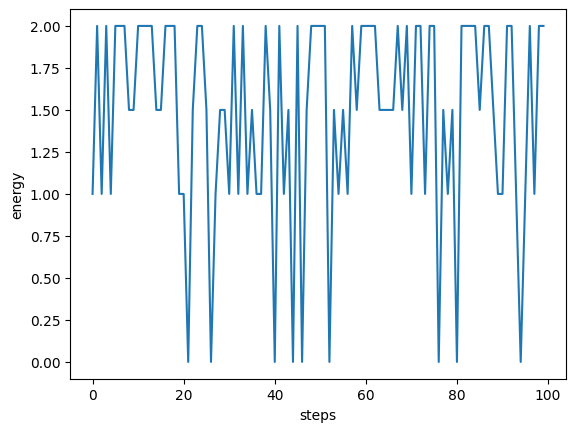

In [59]:
# Train with p = 1
qs = cirq.LineQubit.range(4)
gamma = np.array([1.0])
beta = np.array([1.0])
energies, gamma, beta = gd_train(qs, gamma, beta, 1e-4, 100, 10_000)

print("gamma = ", gamma[0], " beta = ", beta[0])
fig, ax = plt.subplots()
ax.plot(energies)
ax.set_xlabel("steps")
ax.set_ylabel("energy")